## Cloud observations

This notebook simulates microwave and sub-mm observations of idealized clouds in the atmosphere. Its purpose is to illustrate the general radiative properties of clouds observed from space- or airborne remote sensing instruments.

The simulations are performed using the [parts](https://github.com/simonpf/parts) package, which provides a high-level interface to the [Atmospheric Radiative Transfer Simulator (ARTS)](https://www.radiative-transfer.org).

In [82]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
%env ARTS_BUILD_PATH=/home/simonpf/build/arts
from parts.utils.notebook_setup import *

env: ARTS_BUILD_PATH=/home/simonpf/build/arts


## Sensors

Simulations are performed for selected channels from the ICI and MWI passive radiometers.

In [84]:
from parts.sensor import MWI, ICI

mwi = MWI(stokes_dimension = 1, channel_indices = [2, 7, 9, 12, 15])
mwi.sensor_line_of_sight = np.array([180.0])
mwi.sensor_position      = np.array([500e3])

ici = ICI(stokes_dimension = 1, channel_indices = [1, 3, 5, 8, 10])
ici.sensor_line_of_sight = np.array([180.0])
ici.sensor_position      = np.array([500e3])

sensors = [ici, mwi]

Optionally, simulations can also be performed for the CloudSat cloud radar.

In [85]:
from parts.sensor import CloudSat

cloud_sat = CloudSat(stokes_dimension = 1)
cloud_sat.sensor_line_of_sight = np.array([180.0])
cloud_sat.sensor_position      = np.array([500e3])
cloud_sat.range_bins           = np.linspace(0, 20e3, 41) # Edges of range bins [m]

# Uncomment to include CloudSat in simulation.
sensors += [cloud_sat]

## Atmosphere

The following assumptions are made for the radiative transfer calculations:
- One-dimensional atmosphere
- Observations over ocean
- Background atmosphere consisting of oxygen, nitrogen and water vapor

These assumptions are implemented by the `StandardAtmosphere` preconfigured atmosphere model
provided by `parts`.

In [86]:
%load_ext autoreload
%autoreload 2
from parts.models import StandardAtmosphere
atmosphere = StandardAtmosphere()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Atmospheric data

To perform a numeric simulation, in addition to the abstract description of the atmsopheric configuration to be simulated, the specific atmospheric state (i.e. temperature, pressure, and so on) must be known.

For this `parts` provides standard data providers that provide climatological data for typical atmospheric regime.
Here the `Tropical` data provider is used that provides data describing a typical tropical atmosphere.

In [87]:
from parts.data.atmosphere import Tropical
z = np.linspace(0, 20e3, 41)
data_provider = Tropical(z = z)

To illustrate this we can plot the data defining the atmospheric state that is provided by the data provider.

In [88]:
p   = data_provider.get_pressure()
t   = data_provider.get_temperature()
q   = data_provider.get_H2O()

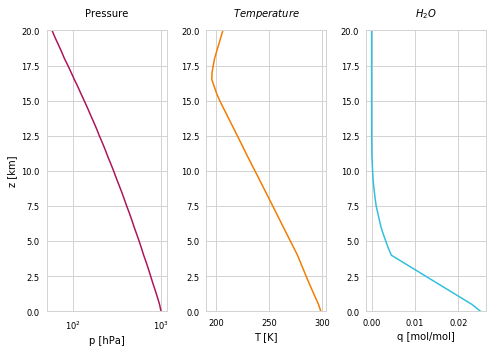

In [89]:
f, axs = plt.subplots(1, 3, figsize = (7, 5))

ax = axs[0]
ax.plot(p / 100, z / 1e3, c = "C0")
ax.set_xscale("log")
ax.set_xlabel("p [hPa]")
ax.set_ylabel("z [km]")
ax.set_ylim([0, 20])
ax.set_title("Pressure")

ax = axs[1]
ax.plot(t, z / 1e3, c = "C1")
ax.set_xlabel("T [K]")
ax.set_ylim([0, 20])
ax.set_title("$Temperature$")

ax = axs[2]
ax.plot(q, z / 1e3, c = "C2")
ax.set_xlabel("q [mol/mol]")
ax.set_ylim([0, 20])
ax.set_title("$H_2O$")

plt.tight_layout()

## Clear sky calculations

To determine the effect of clouds in the atmospheric column, we start with calculating clear-sky radiances as reference value. To run the simulation

In [90]:
from parts.simulation import ArtsSimulation
simulation = ArtsSimulation(atmosphere = atmosphere,
                            sensors = sensors,
                            data_provider = data_provider)
simulation.setup(verbosity = 0)
simulation.run()

In [93]:
f_ici       = np.copy(ici.f_grid)
y_ici_clear = np.copy(ici.y)

f_mwi       = np.copy(mwi.f_grid)
y_mwi_clear = np.copy(mwi.y)

y_cs_clear = np.copy(cloud_sat.y)
z_cs       = cloud_sat.range_bins
z_cs       = 0.5 * (z_cs[1:] + z_cs[:-1])

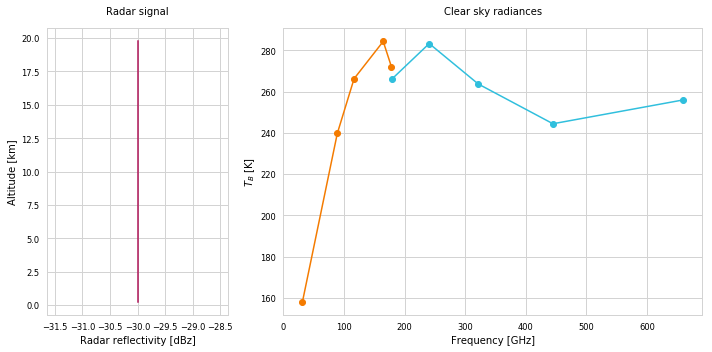

In [94]:
from matplotlib.gridspec import GridSpec
f = plt.figure(figsize = (10, 5))
gs = GridSpec(1, 3)

ax = plt.subplot(gs[0, 0])
ax.plot(y_cs_clear, z_cs / 1e3, c = "C0")
ax.set_xlabel("Radar reflectivity [dBz]")
ax.set_ylabel("Altitude [km]")
ax.set_title("Radar signal")

ax = plt.subplot(gs[0, 1:])
ax.plot(f_mwi / 1e9, y_mwi_clear, c = "C1", marker = "o")
ax.plot(f_ici / 1e9, y_ici_clear, c = "C2", marker = "o")

ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("$T_B$ [K]")
ax.set_title("Clear sky radiances")

plt.tight_layout()

## Adding clouds

To add clouds to the calculations

In [95]:
from parts.scattering.ssdb import shapes
display(shapes)

[EvansSnowAggregate, 6-BulletRosette, LiquidSphere, LargePlateAggregate]

## Liquid cloud

In [96]:
from parts.scattering.psd import D14MN, D14N
from parts.scattering import ScatteringSpecies
psd   = D14MN(alpha = 2.0,    # first shape parameter
              beta  = 1.0,    # second shape parameter
              rho   = 1000.0) # density [kg/m^3]
psd.t_min = 270.0
shape = shapes[2] # Liquid sphere
liquid_cloud = ScatteringSpecies("liquid_cloud", psd, shape)

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


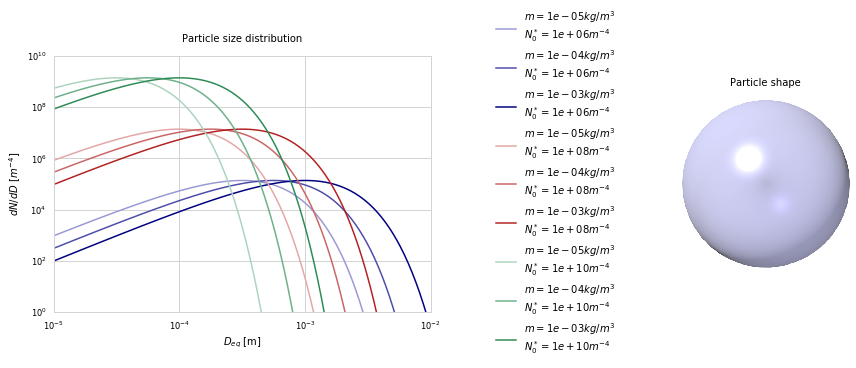

In [97]:
import matplotlib.image as mi
import seaborn as sns

#
# Some colors.
#

sns.reset_orig()
cs = [sns.light_palette("navy", 4),
      sns.light_palette("firebrick", 4),
      sns.light_palette("seagreen", 4)]

#
# Figure setup
#

f  = plt.figure(figsize = (12, 5))
gs = GridSpec(1, 4)

# PSD plots.
ax = plt.subplot(gs[0, 0:2])
x  = np.logspace(-5, -2, 101)
handles = []
labels  = []
for j, n0 in enumerate(np.array([1e6, 1e8, 1e10])):
    for i, md in enumerate(np.array([1e-5, 1e-4, 1e-3])):
        psd.mass_density = md
        psd.intercept_parameter = n0
        y = psd.evaluate(x).data.ravel()
        handles += ax.plot(x, y, c = cs[j][1 + i])
        labels += [r"$m = {0:.0e} kg / m^3$"
                   " \n"
                   r"$N_0^* = {1:.0e} m^{{-4}}$".format(md, n0)]

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim([1e0, 1e10])
ax.set_xlim([1e-5, 1e-2])
ax.set_xlabel("$D_{eq}$ [m]")
ax.set_ylabel("$dN/dD$ [$m^{-4}$]")
ax.set_title("Particle size distribution")

# Legend.
ax  = plt.subplot(gs[0, 2])
ax.legend(handles = handles, labels = labels, ncol = 1, loc = "center")
ax.set_axis_off()


# Shape image.
ax  = plt.subplot(gs[0, 3])
img = mi.imread(shape.img)
ax.imshow(img)
ax.set_aspect(1)
ax.set_axis_off()
ax.set_title("Particle shape")

plt.tight_layout()

## Ice cloud

In [98]:
psd   = D14MN(alpha = -1.0,   # first shape parameter
              beta  = 3.0,    # second shape parameter
              rho   = 917.0) # density [kg/m^3]
psd.t_max = 280.0
shape = shapes[0] # Evans snow aggregate
ice_cloud = ScatteringSpecies("ice_cloud", psd, shape)

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


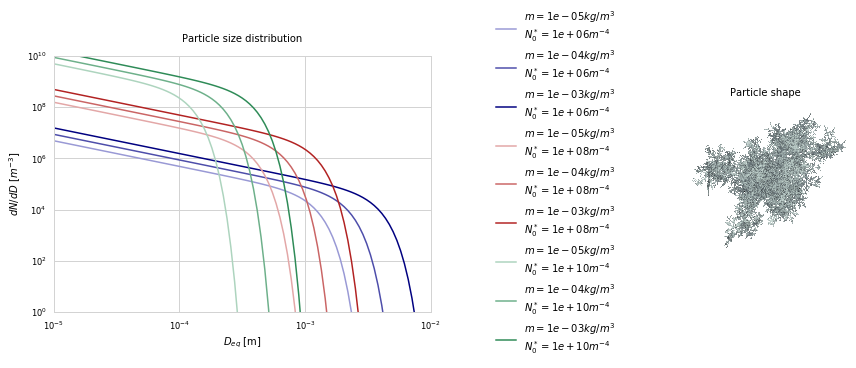

In [99]:
import matplotlib.image as mi
import seaborn as sns

#
# Some colors.
#

sns.reset_orig()
cs = [sns.light_palette("navy", 4),
      sns.light_palette("firebrick", 4),
      sns.light_palette("seagreen", 4)]

#
# Figure setup
#

f  = plt.figure(figsize = (12, 5))
gs = GridSpec(1, 4)

# PSD plots.
ax = plt.subplot(gs[0, 0:2])
x  = np.logspace(-5, -2, 101)
handles = []
labels  = []
for j, n0 in enumerate(np.array([1e6, 1e8, 1e10])):
    for i, md in enumerate(np.array([1e-5, 1e-4, 1e-3])):
        psd.mass_density = md
        psd.intercept_parameter = n0
        y = psd.evaluate(x).data.ravel()
        handles += ax.plot(x, y, c = cs[j][1 + i])
        labels += [r"$m = {0:.0e} kg / m^3$"
                   " \n"
                   r"$N_0^* = {1:.0e} m^{{-4}}$".format(md, n0)]

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim([1e0, 1e10])
ax.set_xlim([1e-5, 1e-2])
ax.set_xlabel("$D_{eq}$ [m]")
ax.set_ylabel("$dN/dD$ [$m^{-3}$]")
ax.set_title("Particle size distribution")

# Legend.
ax  = plt.subplot(gs[0, 2])
ax.legend(handles = handles, labels = labels, ncol = 1, loc = "center")
ax.set_axis_off()


# Shape image.
ax  = plt.subplot(gs[0, 3])
img = mi.imread(shape.img)
ax.imshow(img)
ax.set_aspect(1)
ax.set_axis_off()
ax.set_title("Particle shape")

plt.tight_layout()

## Cloud data

In [110]:
class CloudData:
    def __init__(self, name, z, mass_density = 1e-4, center = 10e3, thickness = 1e3):
        self.z = z 
        self.mass_density = mass_density
        self.center = center
        self.thickness = thickness
        
        self.name = name
        self.__dict__["get_" + name + "_mass_density"] = self.get_mass_density
        self.__dict__["get_" + name + "_intercept_parameter"] = self.get_intercept_parameter
    
    def get_mass_density(self):
        md = self.mass_density * np.exp(- ((z - self.center) / self.thickness) ** 2)
        md[md < 1e-8] = 0.0
        return md
    
    def get_intercept_parameter(self):
        return 1e8 * np.ones(z.size)
    
liquid_cloud_data = CloudData("liquid_cloud", z, mass_density = 5e-4, center = 3e3)
ice_cloud_data    = CloudData("ice_cloud", z, mass_density = 5e-4, center = 10e3, thickness = 2e3)

### Liquid cloud

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=100000000.0, right=100000000.0
  self.set_xlim(upper, lower, auto=None)


Text(0.5, 0, '$D_{eq}$ [m]')

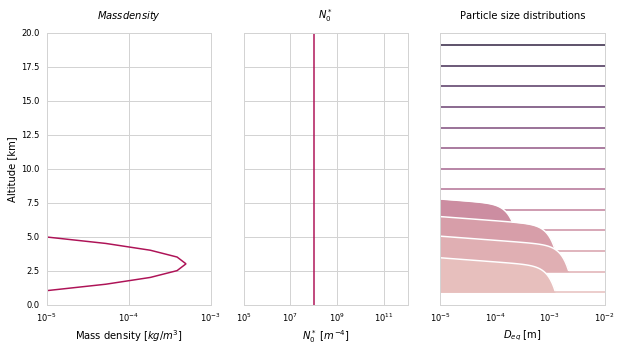

In [111]:
from parts.utils.plots import plot_psds
f, axs = plt.subplots(1, 3, figsize = (10, 5))

md = liquid_cloud_data.get_liquid_cloud_mass_density()
ax = axs[0]
ax.plot(md, z / 1e3)
ax.set_xscale("log")
ax.set_ylim([0, 20])
ax.set_xlim([1e-5, 1e-3])
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("Mass density [$kg / m^3$]")
ax.set_title("$Mass density$")

n0 = liquid_cloud_data.get_liquid_cloud_intercept_parameter()
ax = axs[1]
ax.plot(n0, z / 1e3)
ax.set_xscale("log")
ax.set_ylim([0, 20])
ax.set_xlim([1e5, 1e12])
ax.set_title("$N_0^*$")
ax.set_xlabel("$N_0^*$ $[m^{-4}]$")
ax.yaxis.set_ticklabels([])

x = np.logspace(-5, -2, 101)
psd.mass_density = md
psd.intercept_parameter = n0
y = psd.evaluate(x).data.T
ax = axs[2]
plot_psds(x, y[:, ::3], z[::3] / 1e3, 0.3, 0, ax)
ax.set_xlim([1e-5, 1e-2])
ax.yaxis.set_ticks([])
ax.set_title("Particle size distributions")
ax.set_xlabel("$D_{eq}$ [m]")

### Ice cloud

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=100000000.0, right=100000000.0
  self.set_xlim(upper, lower, auto=None)


Text(0.5, 0, '$D_{eq}$ [m]')

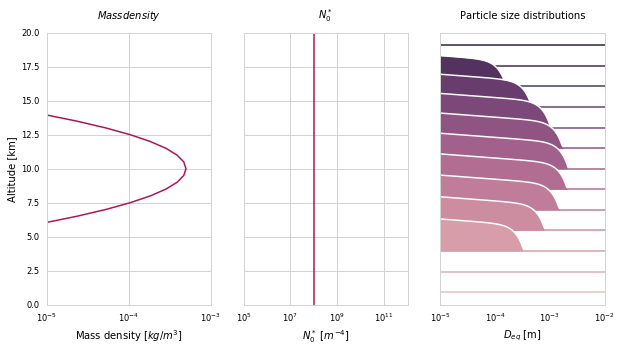

In [112]:
from parts.utils.plots import plot_psds
f, axs = plt.subplots(1, 3, figsize = (10, 5))

md = ice_cloud_data.get_ice_cloud_mass_density()
ax = axs[0]
ax.plot(md, z / 1e3)
ax.set_xscale("log")
ax.set_ylim([0, 20])
ax.set_xlim([1e-5, 1e-3])
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("Mass density [$kg / m^3$]")
ax.set_title("$Mass density$")

n0 = ice_cloud_data.get_ice_cloud_intercept_parameter()
ax = axs[1]
ax.plot(n0, z / 1e3)
ax.set_xscale("log")
ax.set_ylim([0, 20])
ax.set_xlim([1e5, 1e12])
ax.set_title("$N_0^*$")
ax.set_xlabel("$N_0^*$ $[m^{-4}]$")
ax.yaxis.set_ticklabels([])

x = np.logspace(-5, -2, 101)
psd.mass_density = md
psd.intercept_parameter = n0
y = psd.evaluate(x).data.T
ax = axs[2]
plot_psds(x, y[:, ::3], z[::3] / 1e3, 0.3, 1, ax)
ax.set_xlim([1e-5, 1e-2])
ax.yaxis.set_ticks([])
ax.set_title("Particle size distributions")
ax.set_xlabel("$D_{eq}$ [m]")

## Simulating cloudy-sky radiances

In [113]:
atmosphere.scatterers = [liquid_cloud, ice_cloud]

In [114]:
from parts.data_provider import CombinedProvider

data_provider_cloudy      = CombinedProvider(data_provider, liquid_cloud_data, ice_cloud_data)
simulation.data_providery = data_provider_cloudy

In [122]:
from parts.scattering.solvers import Disort
simulation = ArtsSimulation(atmosphere = atmosphere,
                            sensors = [ici, mwi, cloud_sat],
                            data_provider = data_provider_cloudy)
simulation.setup(verbosity = 1)
simulation.run()

ARTS[94320328577008]: Executing /home/simonpf/src/arts/controlfiles/general/general.arts
ARTS[94320328577008]: {
ARTS[94320328577008]: - verbosityInit
ARTS[94320328577008]: - scat_speciesSet
ARTS[94320328577008]: - MatrixSet
ARTS[94320328577008]: - Tensor4SetConstant
ARTS[94320328577008]: - ArrayOfStringSet
ARTS[94320328577008]: - Touch
ARTS[94320328577008]: - Tensor3SetConstant
ARTS[94320328577008]: - ArrayOfStringSet
ARTS[94320328577008]: - MatrixSet
ARTS[94320328577008]: - NumericSet
ARTS[94320328577008]: - ArrayOfStringSet
ARTS[94320328577008]: - Tensor3SetConstant
ARTS[94320328577008]: - Tensor3SetConstant
ARTS[94320328577008]: - Tensor3SetConstant
ARTS[94320328577008]: - Tensor3SetConstant
ARTS[94320328577008]: - Tensor3SetConstant
ARTS[94320328577008]: - Tensor3SetConstant
ARTS[94320328577008]: - IndexSet
ARTS[94320328577008]: - IndexSet
ARTS[94320328577008]: - IndexSet
ARTS[94320328577008]: - IndexSet
ARTS[94320328577008]: - FlagOff
ARTS[94320328577008]: - output_file_formatSet

ARTS[94320328577008]: - ReadXML

ARTS[94320328577008]: - ReadXML

ARTS[94320328577008]: - Append

ARTS[94320328577008]: - Append

ARTS[94320328577008]: - Delete

ARTS[94320328577008]: - Delete

ARTS[94320328577008]: - Append

ARTS[94320328577008]: - Append

ARTS[94320328577008]: - Append

ARTS[94320328577008]: - ReadXML

ARTS[94320328577008]: - ReadXML

ARTS[94320328577008]: - Append

ARTS[94320328577008]: - Append

ARTS[94320328577008]: - Delete

ARTS[94320328577008]: - Delete

ARTS[94320328577008]: - Append

ARTS[94320328577008]: - Append

ARTS[94320328577008]: - Append

ARTS[94320328577008]: - Copy

ARTS[94320328577008]: - TessemNNReadAscii

ARTS[94320328577008]: - TessemNNReadAscii

ARTS[94320328577008]: - Copy

ARTS[94320328577008]: - Copy

ARTS[94320328577008]: - Copy

ARTS[94320328577008]: - Copy

ARTS[94320328577008]: - Copy

ARTS[94320328577008]: - Copy

ARTS[94320328577008]: - Copy

ARTS[94320328577008]: - scat_dataCalc

ARTS[94320328577008]: - Copy

ARTS[94320328577008]: - s

In [123]:
atmosphere.scatterers

In [124]:
y_ici_cloud = np.copy(ici.y)
y_mwi_cloud = np.copy(mwi.y)
y_cs_cloud  = np.copy(cloud_sat.y)

In [125]:
simulation.scattering_solver

## Results

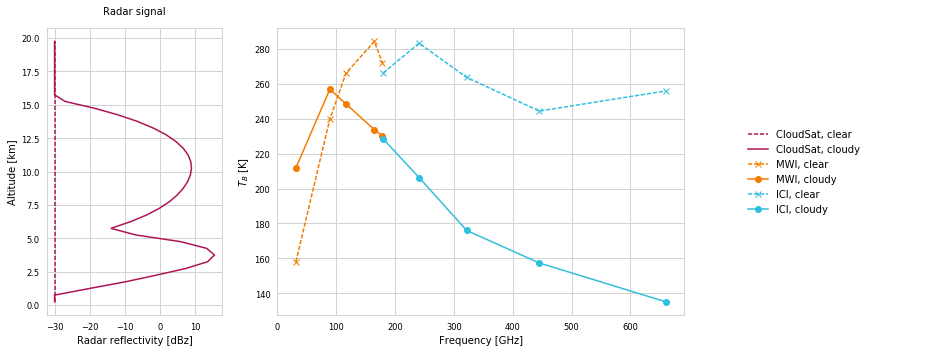

In [132]:
from matplotlib.gridspec import GridSpec
f = plt.figure(figsize = (13, 5))
gs = GridSpec(1, 4)

handles = []
labels  = []

#
# Radar
#

ax = plt.subplot(gs[0, 0])

handles += ax.plot(y_cs_clear, z_cs / 1e3, c = "C0", ls = "--")
labels  += ["CloudSat, clear"]
handles += ax.plot(y_cs_cloud, z_cs / 1e3, c = "C0")
labels  += ["CloudSat, cloudy"]

ax.set_xlabel("Radar reflectivity [dBz]")
ax.set_ylabel("Altitude [km]")
ax.set_title("Radar signal")

#
# Passive
#

ax = plt.subplot(gs[0, 1:3])

handles += ax.plot(f_mwi / 1e9, y_mwi_clear, c = "C1", marker = "x", ls = "--")
labels  += ["MWI, clear"]
handles += ax.plot(f_mwi / 1e9, y_mwi_cloud, c = "C1", marker = "o")
labels  += ["MWI, cloudy"]
handles += ax.plot(f_ici / 1e9, y_ici_clear, c = "C2", marker = "x", ls = "--")
labels  += ["ICI, clear"]
handles += ax.plot(f_ici / 1e9, y_ici_cloud, c = "C2", marker = "o")
labels  += ["ICI, cloudy"]

ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("$T_B$ [K]")

#
# Legend
#

ax = plt.subplot(gs[0, -1])

ax.legend(handles = handles, labels = labels, loc = "center left")
ax.set_axis_off()

plt.tight_layout()

In [47]:
y_ici_clear - y_ici_cloud

array([[3.05703313e+00],
       [2.23485072e+01],
       [2.33100917e+00],
       [5.31812844e-05],
       [1.31802321e+00]])

In [63]:
data_provider_cloudy.get_liquid_cloud_mass_density()
data_provider_cloudy.get_ice_cloud_mass_density()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.29340501e-08,
       6.17049020e-08, 2.59787341e-07, 9.65227068e-07, 3.16485771e-06,
       9.15781944e-06, 2.33853112e-05, 5.26996123e-05, 1.04805694e-04,
       1.83939721e-04, 2.84891412e-04, 3.89400392e-04, 4.69706531e-04,
       5.00000000e-04, 4.69706531e-04, 3.89400392e-04, 2.84891412e-04,
       1.83939721e-04, 1.04805694e-04, 5.26996123e-05, 2.33853112e-05,
       9.15781944e-06, 3.16485771e-06, 9.65227068e-07, 2.59787341e-07,
       6.17049020e-08, 1.29340501e-08, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [58]:
ws = simulation.workspace


In [69]:
simulation.atmosphere.scatterers[1].name

'liquid_cloud'

In [59]:
ws.particle_bulkprop_field.value

array([[[[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]],

        [[0.e+00]]],


       [[[1.e+08]],

        [[1.e+08]],

        [[1.e+08]],

        [[1.e+08]],

        [[1.e+08]],

        [[1.e+08]],

        [[1

In [28]:
atmosphere.scatterers

In [13]:
from parts.scattering.psd.binned import BinnedPSD
from parts.scattering            import ScatteringSpecies
from tests.data                  import scattering_data, scattering_meta

x   = np.logspace(-5, -2, 21)
ice = ScatteringSpecies("ice", BinnedPSD(np.logspace(-5, -2, 21)),
                        scattering_data = scattering_data,
                        scattering_meta_data = scattering_meta)
atmosphere.add_scatterer(ice)

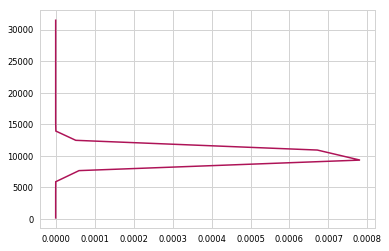

In [14]:
from parts.data.atmosphere import Tropical

z = Tropical().get_altitude()
iwc = 1e-3 * np.exp(- 0.5 * ((z - 10e3) / 1e3) ** 2)
plt.plot(iwc, z)

In [15]:
from parts.data.atmosphere import Tropical
from parts.scattering.psd  import D14MN

class BinnedDataProvider(Tropical):
    def __init__(self, x, md):
        super().__init__()
        t  = self.get_temperature()
        n0 = 1e9 * np.ones(t.shape)
        self.psd = D14MN(mass_density = md, 
                        intercept_parameter = n0,
                        alpha = -1.0, beta = 3.0, rho = 917.0)
        self.y = self.psd.evaluate(x).data
        
        def make_getter(i):
            def get_bin(j = -1):
                x = self.y[:, i]
                if i == j:
                    return x * 1.1
                else:
                    return x
            return get_bin
            
        for i in range(x.size):
            name = "get_ice_bin_" + str(i)
            self.__dict__[name] = make_getter(i)
            

## Simulation

In [16]:
from parts.simulation import ArtsSimulation
simulation = ArtsSimulation(atmosphere = atmosphere,
                            sensors = sensors)
simulation.data_provider = BinnedDataProvider(x, iwc)

In [ ]:
simulation.setup()
simulation.run()
y0_ici = np.copy(ici.y)
y0_mwi = np.copy(mwi.y)

ARTS[93854374401344]: Executing /home/simonpf/src/arts/controlfiles/general/general.arts
ARTS[93854374401344]: {
ARTS[93854374401344]: - verbosityInit
ARTS[93854374401344]: - scat_speciesSet
ARTS[93854374401344]: - MatrixSet
ARTS[93854374401344]: - Tensor4SetConstant
ARTS[93854374401344]: - ArrayOfStringSet
ARTS[93854374401344]: - Touch
ARTS[93854374401344]: - Tensor3SetConstant
ARTS[93854374401344]: - ArrayOfStringSet
ARTS[93854374401344]: - MatrixSet
ARTS[93854374401344]: - NumericSet
ARTS[93854374401344]: - ArrayOfStringSet
ARTS[93854374401344]: - Tensor3SetConstant
ARTS[93854374401344]: - Tensor3SetConstant
ARTS[93854374401344]: - Tensor3SetConstant
ARTS[93854374401344]: - Tensor3SetConstant
ARTS[93854374401344]: - Tensor3SetConstant
ARTS[93854374401344]: - Tensor3SetConstant
ARTS[93854374401344]: - IndexSet
ARTS[93854374401344]: - IndexSet
ARTS[93854374401344]: - IndexSet
ARTS[93854374401344]: - IndexSet
ARTS[93854374401344]: - FlagOff
ARTS[93854374401344]: - output_file_formatSet

ARTS[93854374401344]: - ReadXML

ARTS[93854374401344]: - ReadXML

ARTS[93854374401344]: - Append

ARTS[93854374401344]: - Append

ARTS[93854374401344]: - Delete

ARTS[93854374401344]: - Delete

ARTS[93854374401344]: - Append

ARTS[93854374401344]: - Append

ARTS[93854374401344]: - Append

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - TessemNNReadAscii

ARTS[93854374401344]: - TessemNNReadAscii

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - scat_dataCalc

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - scat_data_checkedCalc

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - Copy

ARTS[93854374401344]: - scat_dataCalc

ARTS[93854374401344]: - Copy



In [ ]:
y1_ici = []
y1_mwi = []
for i in range(21):
    simulation.run(i)
    y1_ici += [np.copy(ici.y)]
    y1_mwi += [np.copy(mwi.y)]

In [ ]:
y1_mwi = np.stack(y1_mwi)
y1_ici = np.stack(y1_ici)

In [ ]:
y1_ici[10, :, 0]

In [ ]:
f, axs = plt.subplots(1, 1, figsize = (10, 5))

ax = axs

x  = mwi.f_grid
ax.plot(x, y0_mwi, marker = "o")

x  = ici.f_grid
ax.plot(x, y0_ici, marker = "o")

In [ ]:
y1_mwi[:, i, 0].shape - y0

In [ ]:
x.shape

In [ ]:
bs

In [ ]:
bs

In [ ]:
mwi.f_grid.size

In [ ]:
from matplotlib.cm import Reds, Blues

f, ax = plt.subplots(1, 1, figsize = (10, 5))
x   = np.logspace(-5, -2, 21)
bs = [Blues(100 + i * 40) for i in range(mwi.f_grid.size)]
for i, f in enumerate(mwi.f_grid):
    plt.plot(x, (y1_mwi[:, i, 0] - y0_mwi[i, 0]) * 10, c = bs[i])

rs = [Reds(100 + i * 40) for i in range(ici.f_grid.size)]
for i, f in enumerate(ici.f_grid):
    plt.plot(x, (y1_ici[:, i, 0] - y0_ici[i, 0]) * 10, c = rs[i])

rs = Reds(ici.f_grid.size * 2)

ax.set_xscale("log")

In [ ]:
plt.plot(y0)
plt.plot(y1[7, :, 0])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ici.y)

In [ ]:
ws = simulation.workspace        
ws.pnd_agenda_input.value

In [ ]:
z   = Tropical().get_altitude()
iwc = 1e-4 * np.ones(z.shape)
iwc[np.logical_or(z < 5e-3, z > 15e3)] = 0.0
dp = BinnedDataProvider(np.logspace(-5, -2, 101), iwc)


In [ ]:
np.logical_or(z < 5e3, z > 15e3)

In [ ]:
plt.plot(x, simulation.data_provider.y.T)
plt.yscale("log")
plt.xscale("log")
plt.ylim([1e-3, 1e10])

In [ ]:
dp.y.data.shape

In [ ]:
dp.get_ice_bin_0()